In [1]:
import theano
import theano.tensor as T
import caffe
import numpy as np

from lasagne.layers.base import Layer
class LPActLayer(Layer):
    """
    Simple rounding layer to mimic the one in Caffe.
    """
    def __init__(self, incoming, bd, ad,
                 **kwargs):
        super(LPActLayer, self).__init__(incoming, **kwargs)
        self.bd = bd
        self.ad = ad

    def get_output_for(self, input, **kwargs):
        return T_round_fp(input, self.bd, self.ad)

#caffe.set_mode_cpu()
def T_round_fp(data, bd, ad):
    bdshift = bd - 1
    adshift = ad - 1
    MAXVAL = float(2 << bdshift) - 1.0/(2<<adshift)    
    return T.clip(T.round(data*(2<<adshift))/(2<<adshift), -MAXVAL, MAXVAL)

def round_fp(data, bd, ad):
    bdshift = bd - 1
    adshift = ad - 1
    MAXVAL = float(2 << bdshift) - 1.0/(2<<adshift)
    return np.clip(np.round(data*(2<<adshift))/(2<<adshift), -MAXVAL, MAXVAL)
print('Ready.')

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5004)


Ready.


In [2]:
prototxt_file='./lp_train_test.prototxt'
weights_file ='./snapshots/lp_lenet_iter_10000.caffemodel'

net = caffe.Net(prototxt_file, weights_file, caffe.TEST)
print('Doing forward pass...')
net.forward()
print('Done.')

Doing forward pass...
Done.


All params in the net: ['conv1', 'conv2', 'ip1', 'ip2']
All blobs in the net: ['data', 'label', 'label_mnist_1_split_0', 'label_mnist_1_split_1', 'conv1', 'lp1', 'pool1', 'tanh1', 'conv2', 'lp2', 'pool2', 'tanh2', 'ip1', 'lp3', 'ip2', 'ip2_ip2_0_split_0', 'ip2_ip2_0_split_1', 'accuracy', 'loss']
Input data shape: (100, 1, 28, 28)


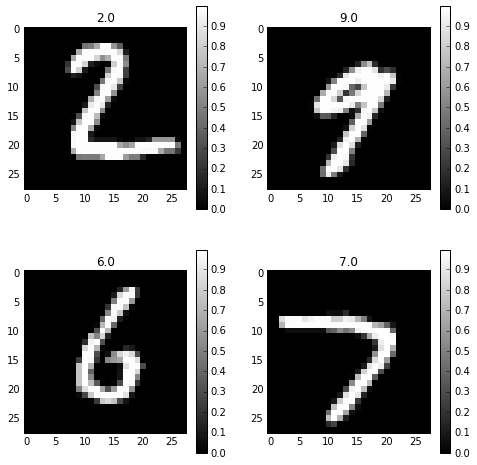

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
%matplotlib inline

print("All params in the net: {}".format(net.params.keys()))
print("All blobs in the net: {}".format(net.blobs.keys()))
# Extract the data
data = net.blobs['data'].data
labels = net.blobs['label'].data
print('Input data shape: {}'.format(data.shape))

# Pick out four images to process
show_data = [1, 20, 50, 70]
plt.figure(figsize=(8,8))
for iter_num, d_idx in enumerate(show_data):
    plt.subplot(2,2,iter_num+1)
    plt.imshow(data[d_idx,0,:,:], interpolation='nearest', cmap='gray')
    plt.title(labels[d_idx])
    plt.colorbar()

('Rounded versions mean diff:', 0.0)


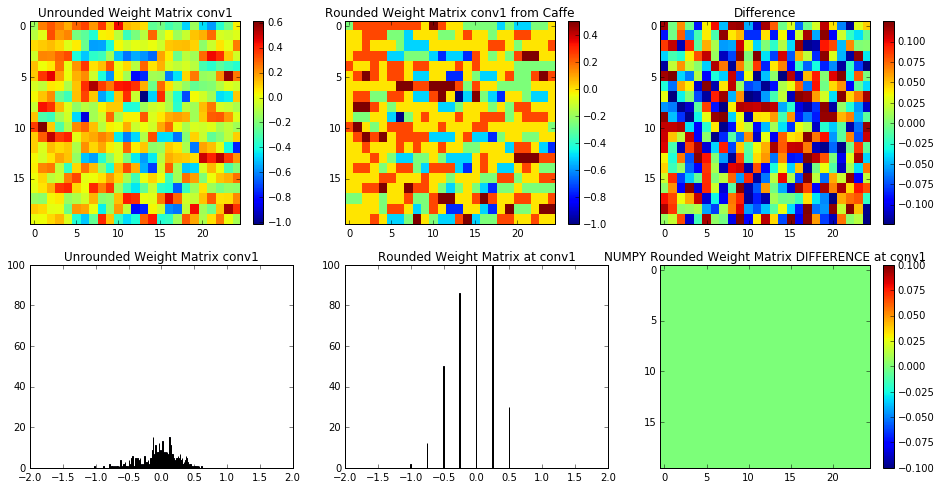

In [4]:
binwidth = 0.01

bd = 2
ad = 2
l_idx = 'conv1'
ymax = 100

def make_2d(data):
    return np.reshape(data, (data.shape[0], -1))

plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.title('Unrounded Weight Matrix {}'.format(l_idx))
plt.imshow(make_2d(net.params[l_idx][0].data), interpolation='nearest', aspect='auto')
plt.colorbar()

plt.subplot(2,3,2)
plt.title('Rounded Weight Matrix {} from Caffe'.format(l_idx))
plt.imshow(make_2d(net.params[l_idx][1].data), interpolation='nearest', aspect='auto')
plt.colorbar()

plt.subplot(2,3,3)
plt.title('Difference')
plt.imshow(make_2d(net.params[l_idx][0].data)-make_2d(net.params[l_idx][1].data), interpolation='nearest', aspect='auto')
plt.colorbar()

plt.subplot(2,3,4)
plt.title('Unrounded Weight Matrix {}'.format(l_idx))
show_data = net.params[l_idx][0].data.flatten()
plt.hist(show_data, bins=np.arange(-2, 2, binwidth))
plt.ylim([0, ymax])

plt.subplot(2,3,5)
plt.title('Rounded Weight Matrix at {}'.format(l_idx))
show_data = net.params[l_idx][1].data.flatten()
plt.hist(show_data, bins=np.arange(-2, 2, binwidth))
plt.ylim([0, ymax])

plt.subplot(2,3,6)
plt.title('NUMPY Rounded Weight Matrix DIFFERENCE at {}'.format(l_idx))
plt.imshow(make_2d(net.params[l_idx][1].data-round_fp(net.params[l_idx][0].data,bd,ad)), 
           interpolation='nearest', aspect='auto')
plt.colorbar()
print('Rounded versions mean diff:', np.mean(np.abs(
        net.params[l_idx][1].data-round_fp(net.params[l_idx][0].data,bd,ad))))

In [5]:
import lasagne
import theano.tensor as T

# Define translation vars
l_translations = {}
l_translations['first_layer_conv']  = 'conv1'
l_translations['second_layer_conv'] = 'conv2'
l_translations['first_dense']       = 'ip1'
l_translations['second_dense']      = 'ip2'

def make_network(input_var):
    # Input layer, as usual:
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)

    network = lasagne.layers.Conv2DLayer(
            network, 
            num_filters=net.params[l_translations['first_layer_conv']][0].data.shape[0], 
            filter_size=(net.params[l_translations['first_layer_conv']][0].data.shape[2], 
                         net.params[l_translations['first_layer_conv']][0].data.shape[3]),
            nonlinearity=lasagne.nonlinearities.linear,
            W=round_fp(net.params[l_translations['first_layer_conv']][0].data[:,:,::-1,::-1],bd,ad),
            b=net.params[l_translations['first_layer_conv']][2].data)
    network = LPActLayer(network, bd, ad)   
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    network = lasagne.layers.NonlinearityLayer(network, lasagne.nonlinearities.tanh)

    network = lasagne.layers.Conv2DLayer(
            network, 
            num_filters=net.params[l_translations['second_layer_conv']][0].data.shape[0], 
            filter_size=(net.params[l_translations['second_layer_conv']][0].data.shape[2], 
                         net.params[l_translations['second_layer_conv']][0].data.shape[3]),
            nonlinearity=lasagne.nonlinearities.linear,
            W=round_fp(net.params[l_translations['second_layer_conv']][0].data[:,:,::-1,::-1],bd,ad),
            b=net.params[l_translations['second_layer_conv']][2].data)        
    network = LPActLayer(network, bd, ad)        
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    network = lasagne.layers.NonlinearityLayer(network,  lasagne.nonlinearities.tanh)
    
    network = lasagne.layers.DenseLayer(
            network,
            num_units=net.params[l_translations['first_dense']][0].data.shape[0],
            nonlinearity=lasagne.nonlinearities.rectify,
            W=round_fp(net.params[l_translations['first_dense']][0].data.T,bd,ad),
            b=net.params[l_translations['first_dense']][2].data)

    network = LPActLayer(network, bd, ad)        

    network = lasagne.layers.DenseLayer(
            network,
            num_units=net.params[l_translations['second_dense']][0].data.shape[0],
            nonlinearity=lasagne.nonlinearities.linear,
            W=round_fp(net.params[l_translations['second_dense']][0].data.T,bd,ad),
            b=net.params[l_translations['second_dense']][2].data)

    network = lasagne.layers.NonlinearityLayer(
            network,
            nonlinearity=lasagne.nonlinearities.softmax)
    return network

# Define symbolic input vars
input_var  = T.ftensor4('my_input_var')
target_var = T.ivector('my_targets')    

network = make_network(input_var)
print('Finished constructing the network.')

print('Building pass functions.')
outs = []
for layer in lasagne.layers.get_all_layers(network):
    outs.append(lasagne.layers.get_output(layer, deterministic=True))
out_fn = theano.function([input_var], outs)
print('Built.')

Finished constructing the network.
Building pass functions.
Built.


Passing test data through network.
Shape Lasagne: (100, 10)
Shape Caffe: (100, 10)
Theano score: 100.000% | Caffe score: 100.000%


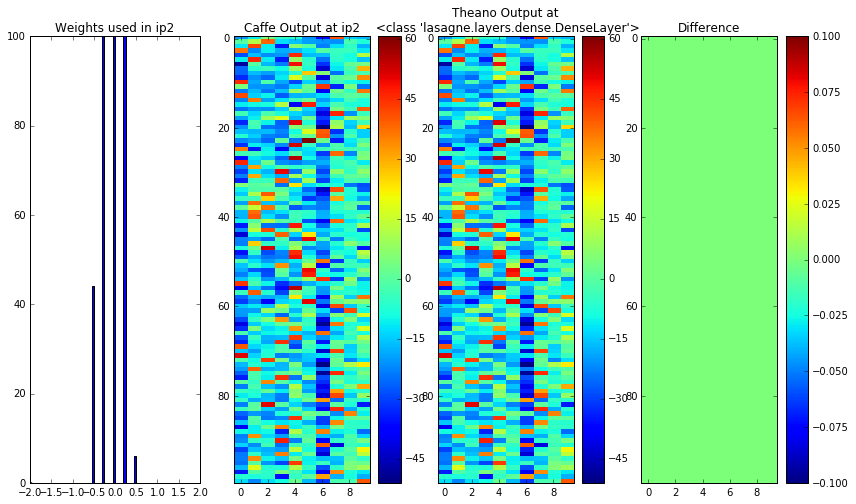

In [10]:
print('Passing test data through network.')
all_outs = out_fn(data)

caffe_layer = 'ip2'
l_idx = 11
l_data = net.blobs[caffe_layer].data
l_data_rs = np.reshape(l_data, (l_data.shape[0], -1)) 
l_out_data = np.reshape(all_outs[l_idx], (all_outs[l_idx].shape[0], -1)) 
print('Shape Lasagne: {}'.format(all_outs[l_idx].shape))
print('Shape Caffe: {}'.format(l_data.shape))

plt.figure(figsize=(14,8))
plt.subplot(1,4,1)
plt.title('Weights used in {}'.format(caffe_layer))
plt.hist(lasagne.layers.get_all_layers(network)[l_idx].W.get_value().flatten(),
         bins=np.arange(-2, 2, 0.05))
plt.ylim([0, 100])
plt.subplot(1,4,2)
plt.title('Caffe Output at {}'.format(caffe_layer))
plt.imshow(l_data_rs, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.subplot(1,4,3)
plt.title('Theano Output at\n {}'.format(type(lasagne.layers.get_all_layers(network)[l_idx])))
plt.imshow(l_out_data, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.subplot(1,4,4)
plt.title('Difference')
plt.imshow(l_data_rs[:,:]-l_out_data, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.savefig('double_check.png')

theano_score = np.mean(np.argmax(all_outs[-1], axis=1)==labels)*100.
print('Theano score: {:2.3f}% | Caffe score: {:2.3f}%'.format(theano_score, 100.*float(net.blobs['accuracy'].data)))